# Оптимизация нейронных сетей. Метод обратного распространения ошибки (ноутбук)

> Узнаем как устроена оптимизация нейронных сетей. Оптимизация в `PyTorch`.

## План ноутбука

1. Высокоуровневое API для обучение нейросетей в `PyTorch`
2. Обучение первой нейросети в `PyTorch`

## Высокоуровневое API для обучение нейросетей в `PyTorch`

In [1]:
import torch
import torch.nn as nn

### Создание объекта нейросети

In [2]:
net = nn.Sequential(
    nn.Linear(700, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
)

In [3]:
net

Sequential(
  (0): Linear(in_features=700, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=200, bias=True)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=10, bias=True)
)

In [8]:
input = torch.randn((5, 700))

In [9]:
net(input)

tensor([ 0.1243,  0.1015,  0.0204, -0.0929, -0.0106, -0.0711, -0.0951,  0.0568,
        -0.0062, -0.0565], grad_fn=<AddBackward0>)

In [10]:
from collections import OrderedDict

net = nn.Sequential(
    OrderedDict(
        [
            ('linear1', nn.Linear(700, 500)),
            ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(500, 200)),
            ('relu2', nn.ReLU()),
            ('linear3', nn.Linear(200, 10))
        ]
    )
)

In [13]:
net.linear1.weight

Parameter containing:
tensor([[ 0.0007,  0.0133, -0.0091,  ..., -0.0121, -0.0312, -0.0300],
        [ 0.0168,  0.0251,  0.0177,  ..., -0.0167, -0.0076, -0.0359],
        [-0.0148,  0.0041, -0.0047,  ...,  0.0003, -0.0219,  0.0272],
        ...,
        [ 0.0036, -0.0062, -0.0163,  ...,  0.0011, -0.0071, -0.0123],
        [ 0.0081,  0.0096, -0.0131,  ..., -0.0180, -0.0154, -0.0330],
        [-0.0334,  0.0270,  0.0030,  ...,  0.0306,  0.0221, -0.0282]],
       requires_grad=True)

In [14]:
input_tensor = torch.rand(10, 700)

net(input_tensor).shape

torch.Size([10, 10])

In [17]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(700, 500)
        self.linear2 = nn.Linear(500, 200)
        self.linear3 = nn.Linear(200, 10)

        self.activation = nn.ReLU()

    def forward(self, x):
        if self.training:
        output = self.activation(self.linear1(x))
        output = self.activation(self.linear2(output))
        output = self.linear3(output)

        return output

In [48]:
net = CustomTaskNetwork()

net(input_tensor).shape

torch.Size([10, 10])

In [20]:
net.to("cuda:0").linear1.weight

Parameter containing:
tensor([[ 0.0281,  0.0208,  0.0306,  ..., -0.0007,  0.0024,  0.0054],
        [-0.0174, -0.0146, -0.0151,  ...,  0.0358, -0.0071, -0.0036],
        [-0.0357,  0.0049,  0.0376,  ..., -0.0005,  0.0198,  0.0287],
        ...,
        [-0.0006,  0.0184, -0.0227,  ..., -0.0194, -0.0218, -0.0158],
        [-0.0376,  0.0078,  0.0292,  ..., -0.0355, -0.0096, -0.0303],
        [ 0.0071, -0.0342, -0.0029,  ..., -0.0242, -0.0343,  0.0070]],
       device='cuda:0', requires_grad=True)

In [22]:
net.train()
net.eval()

net.requires_grad_(False)

CustomTaskNetwork(
  (linear1): Linear(in_features=700, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=10, bias=True)
  (activation): ReLU()
)

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7f1bb7512e50>

In [ ]:
n = next(iter(net.parameters()))
n

Parameter containing:
tensor([[-0.0026, -0.0227, -0.0359,  ..., -0.0075, -0.0199, -0.0076],
        [ 0.0015, -0.0034, -0.0024,  ...,  0.0200,  0.0053, -0.0170],
        [ 0.0271, -0.0176,  0.0117,  ...,  0.0093, -0.0210,  0.0335],
        ...,
        [-0.0155, -0.0191,  0.0222,  ...,  0.0097, -0.0012,  0.0194],
        [-0.0010,  0.0169, -0.0184,  ...,  0.0222,  0.0137,  0.0349],
        [-0.0103,  0.0035,  0.0085,  ...,  0.0144, -0.0296, -0.0027]],
       requires_grad=True)

In [ ]:
type(n)

torch.nn.parameter.Parameter

In [28]:
weights

OrderedDict([('linear1.weight',
              tensor([[ 0.0281,  0.0208,  0.0306,  ..., -0.0007,  0.0024,  0.0054],
                      [-0.0174, -0.0146, -0.0151,  ...,  0.0358, -0.0071, -0.0036],
                      [-0.0357,  0.0049,  0.0376,  ..., -0.0005,  0.0198,  0.0287],
                      ...,
                      [-0.0006,  0.0184, -0.0227,  ..., -0.0194, -0.0218, -0.0158],
                      [-0.0376,  0.0078,  0.0292,  ..., -0.0355, -0.0096, -0.0303],
                      [ 0.0071, -0.0342, -0.0029,  ..., -0.0242, -0.0343,  0.0070]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([-0.0017, -0.0131, -0.0063, -0.0182, -0.0309,  0.0208, -0.0358, -0.0007,
                       0.0054,  0.0199, -0.0127,  0.0032, -0.0303,  0.0249,  0.0078,  0.0278,
                       0.0361,  0.0121,  0.0068,  0.0298,  0.0325, -0.0312,  0.0198,  0.0292,
                      -0.0363, -0.0231, -0.0372, -0.0200, -0.0204,  0.0104,  0.0037,

In [24]:
torch.save(net.state_dict(), "weights.pth")

In [29]:
weights = torch.load("weights.pth")
net.to("cuda:0")
net.load_state_dict(weights)
net.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0281,  0.0208,  0.0306,  ..., -0.0007,  0.0024,  0.0054],
                      [-0.0174, -0.0146, -0.0151,  ...,  0.0358, -0.0071, -0.0036],
                      [-0.0357,  0.0049,  0.0376,  ..., -0.0005,  0.0198,  0.0287],
                      ...,
                      [-0.0006,  0.0184, -0.0227,  ..., -0.0194, -0.0218, -0.0158],
                      [-0.0376,  0.0078,  0.0292,  ..., -0.0355, -0.0096, -0.0303],
                      [ 0.0071, -0.0342, -0.0029,  ..., -0.0242, -0.0343,  0.0070]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([-0.0017, -0.0131, -0.0063, -0.0182, -0.0309,  0.0208, -0.0358, -0.0007,
                       0.0054,  0.0199, -0.0127,  0.0032, -0.0303,  0.0249,  0.0078,  0.0278,
                       0.0361,  0.0121,  0.0068,  0.0298,  0.0325, -0.0312,  0.0198,  0.0292,
                      -0.0363, -0.0231, -0.0372, -0.0200, -0.0204,  0.0104,  0.0037,

Если мы хотим проинициализировать сетку какими-то весами из словаря, то важно чтобы названия и размеры параметров в передаваемом словаре совпадали с названиями и размерами параметров сетки

In [23]:
net.load_state_dict({'linear5.weight': torch.rand((1, 2, 3))})

RuntimeError: Error(s) in loading state_dict for CustomTaskNetwork:
	Missing key(s) in state_dict: "linear1.weight", "linear1.bias", "linear2.weight", "linear2.bias", "linear3.weight", "linear3.bias". 
	Unexpected key(s) in state_dict: "linear5.weight". 

### Оптимизаторы

In [31]:
from torch import optim

In [32]:
optim.SGD, optim.AdamW

(torch.optim.sgd.SGD, torch.optim.adamw.AdamW)

In [33]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [34]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [36]:
optimizer = optim.SGD(
    [
        {'params': net.linear1.parameters()},
        {'params': net.linear2.parameters(), 'lr': 1e-3}
    ],
    lr=1e-2,
    momentum=0.9
)

In [37]:
optimizer.step()

In [38]:
optimizer.zero_grad()

### Функции потерь

In [39]:
nn.L1Loss, nn.MSELoss, nn.CrossEntropyLoss

(torch.nn.modules.loss.L1Loss,
 torch.nn.modules.loss.MSELoss,
 torch.nn.modules.loss.CrossEntropyLoss)

In [40]:
loss = nn.MSELoss()

In [50]:

input = net(input_tensor)
target = torch.randn(10, 10)

output = loss(input, target)

print(output)

output.backward()

tensor(0.9249, grad_fn=<MseLossBackward0>)


In [51]:
net.linear1.weight.grad

tensor([[-4.4235e-05,  2.5569e-04,  1.2864e-03,  ...,  6.2083e-04,
          8.4409e-04,  6.0548e-04],
        [ 6.4985e-05, -6.4315e-04,  2.1371e-05,  ..., -2.8393e-04,
          3.7843e-04,  1.0386e-04],
        [-5.2941e-04, -1.7630e-04, -7.5793e-04,  ..., -4.5321e-04,
         -7.4924e-04, -4.4576e-04],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.0254e-04,  1.0432e-03,  1.6975e-03,  ...,  1.1321e-03,
          1.9869e-03,  1.2786e-03],
        [-4.2786e-04, -2.6169e-04, -1.5095e-04,  ..., -3.8798e-06,
         -4.3369e-04, -4.4545e-04]])

### Датасеты и даталоадеры

In [52]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset

In [53]:
n_features = 2
n_objects = 300

torch.manual_seed(0)

In [11]:
w_true = torch.randn(n_features)

X = (torch.rand(n_objects, n_features) - 0.5) * 10
X *= (torch.arange(n_features) * 2 + 1)
Y = (X @ w_true + torch.randn(n_objects)).unsqueeze(1)

In [ ]:
X.shape, Y.shape

(torch.Size([300, 2]), torch.Size([300, 1]))

In [ ]:
dataset = TensorDataset(X, Y)

In [ ]:
dataset[7]

(tensor([-3.3897, -6.5319]), tensor([-3.7483]))

In [ ]:
X[7], Y[7]

(tensor([-3.3897, -6.5319]), tensor([-3.7483]))

In [80]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Lambda

dataset = MNIST("./mnist_example", transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]), download=True)

In [81]:
dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [87]:
for sample in loader:
    print(sample)
    break

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 9, 9, 5, 7, 6, 7, 9, 5, 8, 8, 5, 6, 2, 8, 1])]


In [88]:
dataset[0][0].shape

torch.Size([784])

In [74]:
28 * 28

784

### Общая структура обучения модели

Модель

In [102]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear1 = nn.Linear(784, 500)
        self.linear2 = nn.Linear(500, 200)
        self.linear3 = nn.Linear(200, 10)

        self.activation = nn.ReLU()

    def forward(self, x):
        output = self.activation(self.linear1(x))
        output = self.activation(self.linear2(output))
        output = self.linear3(output)

        return output

model = CustomTaskNetwork()

Оптимизатор

In [103]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Функция потерь

In [92]:
loss_fn = nn.CrossEntropyLoss()

Данные

In [95]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Lambda

dataset = MNIST("./mnist_example", transform=Compose([ToTensor(), Lambda(lambda x: torch.flatten(x))]), download=True)

batch_size = 1
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

Обучение

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

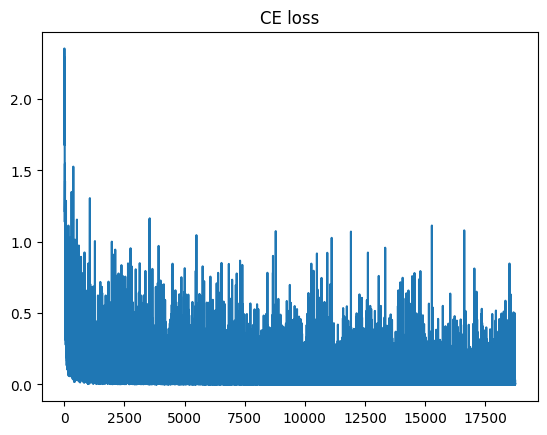

In [104]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

model.train()

loss_history = []
for epoch in range(5):
    for x, y in tqdm(loader, desc="Training"):
    #     optimizer.zero_grad()

        output = model(x)  # forward: net

    #     optimizer.zero_grad()

        loss = loss_fn(output, y)  # forward: loss
        
        loss_history += [loss.item()]  # сохранение статистик

        optimizer.zero_grad()

        loss.backward()  # backward

        optimizer.step()
    
plt.plot(loss_history)
plt.title("CE loss")
plt.show()

Сохранение обученной модели

In [105]:
torch.save(model.state_dict(), "my_model.pth")

Применение обученной модели для получения предсказания

In [110]:
model.eval()

with torch.no_grad():
    print(torch.argmax(model(dataset[0][0])))

tensor(5)


In [111]:
dataset = MNIST("./mnist_example")
dataset[0][0]

и правда

### Код из прошлого года, для самостоятельного разбора

## Обучение первой нейросети в `PyTorch`

In [14]:
class CustomTaskNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

loss_fn = nn.MSELoss()

dataset = TensorDataset(X, Y)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

w_list = torch.empty(len(loader) + 1, n_features)

In [15]:
import matplotlib.pyplot as plt

In [16]:
net.train()
loss_progress = []

for i, (x, y) in enumerate(loader):
    w_list[i] = net.linear.weight.detach().clone()

    optimizer.zero_grad()

    output = net(x)

    loss = loss_fn(output, y)

    print(f'MSE на шаге {i} {loss.item():.5f}')

    loss.backward()

    optimizer.step()
    loss_progress.append(loss.item())

w_list[len(loader)] = net.linear.weight.detach().clone()

MSE на шаге 0 242.01245
MSE на шаге 1 134.32031
MSE на шаге 2 123.18914
MSE на шаге 3 64.54957
MSE на шаге 4 65.94706
MSE на шаге 5 67.34977
MSE на шаге 6 102.08151
MSE на шаге 7 43.03222
MSE на шаге 8 24.57300
MSE на шаге 9 36.63132
MSE на шаге 10 24.60014
MSE на шаге 11 7.33985
MSE на шаге 12 6.01970
MSE на шаге 13 3.31219
MSE на шаге 14 1.04856
MSE на шаге 15 5.89304
MSE на шаге 16 1.37320
MSE на шаге 17 0.52057
MSE на шаге 18 0.41577
MSE на шаге 19 2.85196
MSE на шаге 20 1.97716
MSE на шаге 21 1.19751
MSE на шаге 22 3.05991
MSE на шаге 23 0.38070
MSE на шаге 24 3.05506
MSE на шаге 25 4.58498
MSE на шаге 26 8.62303
MSE на шаге 27 4.19627
MSE на шаге 28 2.57163
MSE на шаге 29 9.31051
MSE на шаге 30 2.24967
MSE на шаге 31 11.35344
MSE на шаге 32 6.00886
MSE на шаге 33 3.57904
MSE на шаге 34 11.42112
MSE на шаге 35 5.28102
MSE на шаге 36 1.88774
MSE на шаге 37 6.75627
MSE на шаге 38 1.71659
MSE на шаге 39 1.10073
MSE на шаге 40 1.45695
MSE на шаге 41 3.34100
MSE на шаге 42 2.09145
MSE 

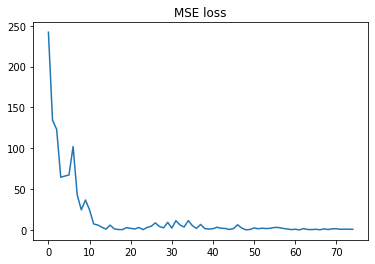

In [20]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.show()

In [19]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)

А вот что будет, если забудете сделать optimizer.zero_grad()

In [21]:
net = CustomTaskNetwork()
optimizer = optim.Adam(net.parameters(), lr=1e-1)
loss_fn = nn.MSELoss()
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
w_list = torch.empty(len(loader) + 1, n_features)

net.train()
loss_progress = []

for i, (x, y) in enumerate(loader):
    w_list[i] = net.linear.weight.detach().clone()

    # optimizer.zero_grad()

    output = net(x)

    loss = loss_fn(output, y)

    print(f'MSE на шаге {i} {loss.item():.5f}')

    loss.backward()

    optimizer.step()
    loss_progress.append(loss.item())

w_list[len(loader)] = net.linear.weight.detach().clone()

MSE на шаге 0 6.64136
MSE на шаге 1 6.32261
MSE на шаге 2 4.81098
MSE на шаге 3 2.65582
MSE на шаге 4 5.01655
MSE на шаге 5 2.49205
MSE на шаге 6 0.55801
MSE на шаге 7 0.89445
MSE на шаге 8 5.16141
MSE на шаге 9 6.55043
MSE на шаге 10 4.50841
MSE на шаге 11 7.17688
MSE на шаге 12 5.68755
MSE на шаге 13 1.02357
MSE на шаге 14 4.12161
MSE на шаге 15 1.86803
MSE на шаге 16 11.72225
MSE на шаге 17 16.07097
MSE на шаге 18 54.77718
MSE на шаге 19 48.88470
MSE на шаге 20 9.92812
MSE на шаге 21 26.46951
MSE на шаге 22 21.79064
MSE на шаге 23 83.94159
MSE на шаге 24 23.48804
MSE на шаге 25 13.53572
MSE на шаге 26 69.68819
MSE на шаге 27 16.66347
MSE на шаге 28 12.04454
MSE на шаге 29 1.21379
MSE на шаге 30 17.71037
MSE на шаге 31 2.63841
MSE на шаге 32 9.35547
MSE на шаге 33 27.83498
MSE на шаге 34 15.75448
MSE на шаге 35 25.87412
MSE на шаге 36 21.04153
MSE на шаге 37 13.39895
MSE на шаге 38 88.76398
MSE на шаге 39 42.34043
MSE на шаге 40 145.78154
MSE на шаге 41 127.93519
MSE на шаге 42 190.3

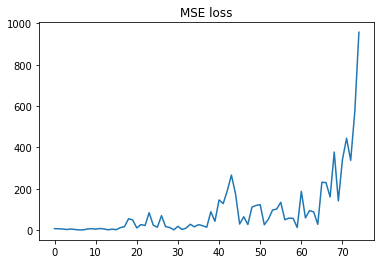

In [22]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.show()

In [23]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)

Теперь обучим сеть в несколько эпох

In [29]:
num_epochs = 5

w_list = torch.empty(len(loader) * num_epochs + 1, n_features)

net = CustomTaskNetwork()

optimizer = optim.Adam(net.parameters(), lr=1e-1)

In [30]:
net.train()

loss_progress = []

for epoch in range(num_epochs):
    total_loss = 0

    for i, (x, y) in enumerate(loader):
        w_list[i + epoch * len(loader)] = net.linear.weight.detach().clone()

        optimizer.zero_grad()

        output = net(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        loss_progress.append(loss.item())

        loss.backward()

        optimizer.step()

    total_loss /= len(loader)

    print(f'MSE после эпохи {epoch} {total_loss:.5f}')

w_list[len(loader) * num_epochs] = net.linear.weight.detach().clone()

MSE после эпохи 0 4.36653
MSE после эпохи 1 1.21639
MSE после эпохи 2 1.25964
MSE после эпохи 3 1.34328
MSE после эпохи 4 1.34536


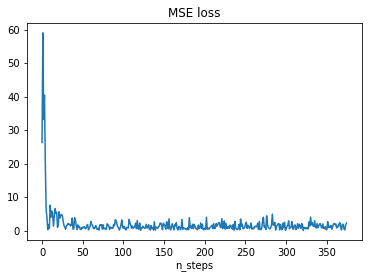

In [31]:
plt.plot(list(range(len(loss_progress))), loss_progress)
plt.title("MSE loss")
plt.xlabel("n_steps")
plt.show()

In [32]:
from plot_trajectory import plot_trajectory

plot_trajectory(
    w_list.numpy(),
    w_true.numpy(),
    X.numpy(),
    Y.squeeze(1).numpy(),
    'Mini-batch градиентный спуск'
)